In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# setup disply parameters
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
from matplotlib.ticker import StrMethodFormatter
float_formatter = StrMethodFormatter('{x:0.03f}')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(18, 6)) # set figure size

## Running a Negotiation

NegMAS has several built-in negotiation `Mechanism` s, negotiation agents (`Negotiator` s), and `UtilityFunction` s. You can use these to run negotiations as follows:

In [2]:
import random # for generating random ufuns
random.seed(0) # for reproducibility
from pprint import pprint # for printing
from negmas import SAOMechanism, AspirationNegotiator, MappingUtilityFunction

session = SAOMechanism(outcomes=10, n_steps=100)
negotiators = [AspirationNegotiator(name=f'a{_}') for _ in range(5)]
for negotiator in negotiators:
    session.add(negotiator, preferences=MappingUtilityFunction(lambda x: random.random() * x[0]))

pprint(vars(session.run()))

{'agreement': (9,),
 'broken': False,
 'current_offer': (9,),
 'current_proposer': 'a2-bb589c3b-9c39-480f-a31b-4e82831f53da',
 'current_proposer_agent': None,
 'error_details': '',
 'has_error': False,
 'last_negotiator': <negmas.sao.negotiators.AspirationNegotiator object at 0x10fb68880>,
 'n_acceptances': 0,
 'n_negotiators': 5,
 'new_offerer_agents': [],
 'new_offers': [],
 'relative_time': 0.297029702970297,
 'results': None,
 'running': False,
 'started': True,
 'step': 29,
 'time': 0.006957488000001177,
 'timedout': False,
 'waiting': False}


Negotations end with a status that shows you what happens. In the above example, we can see that the negotiation was not broken and did not time-out. The agreement was on outcome `(9,)` of the *10* possible outcomes of this negotiation. That offer was offered by negotiator `a3` (the rest of the agent *ID* is always a random value to ensure no name repetitions) in the `9`th round of the negotiation (rounds/steps start at `0`) and was accepted by all of the other *4* negotiators. The whole negotiation took `4.66` ms.

Let's look at this code example line-by-line:

```python
session = SAOMechanism(outcomes=10, n_steps=100)
```

The negotiation protocol in NegMAS is handled by a `Mechanism` object. Here we instantiate an `SAOMechanism` which implements the [**Stacked Alternating Offers Protocol**](https://ii.tudelft.nl/~catholijn/publications/sites/default/files/Aydogan2017_Chapter_AlternatingOffersProtocolsForM.pdf). In this protocol, negotiators exchange offers until an offer is accepted by all negotiators, a negotiators leaves the table ending the negotiation or a time-out condition is met. In the example above, we use a limit on the number of rounds (defined by a number of offers equal to the number of negotiators) of `100` (a step of a mechanism is an executed round). Another possibility here is to pass a wall-time constraint using something like `time_limit=10` which limits the negotiation to `10` seconds. 

The negotiation agenda can be specified in two ways:

1. You can pass `outcomes=x` to create a negotiation agenda with a single issue of `x` values. In this example we use this approach to create a single issue negotiation with `10` outcomes. These outcomes will be tuples of one item each ranging from `(0,)` to `(9,)`.
2. You can pass `issues=x` to create a multi-issue negotiation as we will see later in this tutorial. We can use this approach to achieve the same result as above by replacing `outcomes=10` with `issues=[make_issue(10)]` in the sample code above.

```python
negotiators = [AspirationNegotiator(name=f'a{_}') for _ in range(5)]
```

This line creates `5` negotiators of the type `AspirationNegotiator` which implements a simple time-based negotiation strategy. It starts by offering the outcome with maximum utility for itself and then concedes (i.e. offers outcomes with lower utility) based on the relative time of the negotiation.

```python
for negotiator in negotiators:
    session.add(negotiator, preferences=MappingUtilityFunction(lambda x: random.random() * x[0]))
```

This loop *adds* the negotiators to the negotiation session (the `SAOMechanism` we created earlier). Most negotiators need access to a utility function that defines its preferences over different outcomes. Here we use a `MappintUtilityFunction` which is passed any python callable (i.e. a function, lambda expression, a class implementing `__call__`, ...) and uses it to calculate the utility of a given outcome. 

The lambda expression used here (`lambda x: random.random() * x[0]`) extracts the first value of the outcome (which will be an integer from `0` to `9`) and multiplies it with a random number *each time it is called*. This means that calling this utility function twice with the same outcome results in two different values. This may not be particularly useful but it shows that the utility function can *change* during the negotiation and NegMAS provides some support for this which we will discuss in later tutorials.

Now the last line runs the negotiation using the `run()` method of the `SAOMechanism` object, converts the result to a dictionary using `var` and prints it. 

### A simple bilateral negotiation

Let's try a more meaningful situation:
Assume we have a buyer and a seller who are negotiating about a business transaction in which the buyer wants to maximize his profit while the seller wants to minimize her cost. They both would like to transact on as much as possible of the product and each has some preferred delivery time.

This can be modeled in the following negotiation:


In [3]:
from negmas import make_issue, SAOMechanism, AspirationNegotiator, normalize
from negmas.preferences import LinearUtilityAggregationFunction as LUFun

# create negotiation agenda (issues)
issues = [
    make_issue(name='price', values=10),
    make_issue(name='quantity', values=(1, 11)),
    make_issue(name='delivery_time', values=10)
]

# create the mechanism
session = SAOMechanism(issues=issues, n_steps=20)

# define buyer and seller utilities
seller_utility =  LUFun(
        values=[
            lambda x: x, 
            lambda x: 0.2 * x, 
            lambda x: 9.0 - x
        ],
    )

buyer_utility = normalize(
    LUFun(
        values={
            'price': lambda x: 9.0 - x, 
            'quantity': lambda x: 0.2 * x, 
            'delivery_time': lambda x: x
        },
    ),
    outcomes=session.outcomes,
)

# create and add buyer and seller negotiators
session.add(AspirationNegotiator(name='buyer'), ufun=buyer_utility)
session.add(AspirationNegotiator(name='seller'), ufun=seller_utility)

# run the negotiation and show the results
pprint(vars(session.run()))

{'agreement': (9, 9, 8),
 'broken': False,
 'current_offer': (9, 9, 8),
 'current_proposer': 'seller-94e49753-cca3-445c-88ee-6f1921064039',
 'current_proposer_agent': None,
 'error_details': '',
 'has_error': False,
 'last_negotiator': <negmas.sao.negotiators.AspirationNegotiator object at 0x10fb68fa0>,
 'n_acceptances': 0,
 'n_negotiators': 2,
 'new_offerer_agents': [],
 'new_offers': [],
 'relative_time': 0.9047619047619048,
 'results': None,
 'running': False,
 'started': True,
 'step': 18,
 'time': 0.004228737000000038,
 'timedout': False,
 'waiting': False}


In this run, we can see that the agreement was on a high price (*9*) which is preferred by the seller but with a delivery time of *8* which is preferred by the buyer. Negotiation took *17* steps out of the allowed *20* (*90%* of the available time)


We can check the negotiation history as well


In [4]:
for i, _ in enumerate(session.history):
    print(f'{i:03}: {_.new_offers}')

000: [('buyer-14e96ed5-7752-4851-92a0-eedab09a73ab', (0, 11, 9)), ('seller-94e49753-cca3-445c-88ee-6f1921064039', (9, 11, 0))]
001: [('buyer-14e96ed5-7752-4851-92a0-eedab09a73ab', (0, 11, 9)), ('seller-94e49753-cca3-445c-88ee-6f1921064039', (9, 11, 0))]
002: [('buyer-14e96ed5-7752-4851-92a0-eedab09a73ab', (0, 11, 9)), ('seller-94e49753-cca3-445c-88ee-6f1921064039', (9, 11, 0))]
003: [('buyer-14e96ed5-7752-4851-92a0-eedab09a73ab', (0, 11, 9)), ('seller-94e49753-cca3-445c-88ee-6f1921064039', (9, 11, 0))]
004: [('buyer-14e96ed5-7752-4851-92a0-eedab09a73ab', (0, 11, 9)), ('seller-94e49753-cca3-445c-88ee-6f1921064039', (9, 11, 0))]
005: [('buyer-14e96ed5-7752-4851-92a0-eedab09a73ab', (0, 11, 9)), ('seller-94e49753-cca3-445c-88ee-6f1921064039', (9, 11, 0))]
006: [('buyer-14e96ed5-7752-4851-92a0-eedab09a73ab', (0, 10, 9)), ('seller-94e49753-cca3-445c-88ee-6f1921064039', (9, 10, 0))]
007: [('buyer-14e96ed5-7752-4851-92a0-eedab09a73ab', (0, 9, 9)), ('seller-94e49753-cca3-445c-88ee-6f1921064039'

We can even plot the complete negotiation history and visually see how far were the result from the pareto frontier (it was 0.0 utility units far from it). 

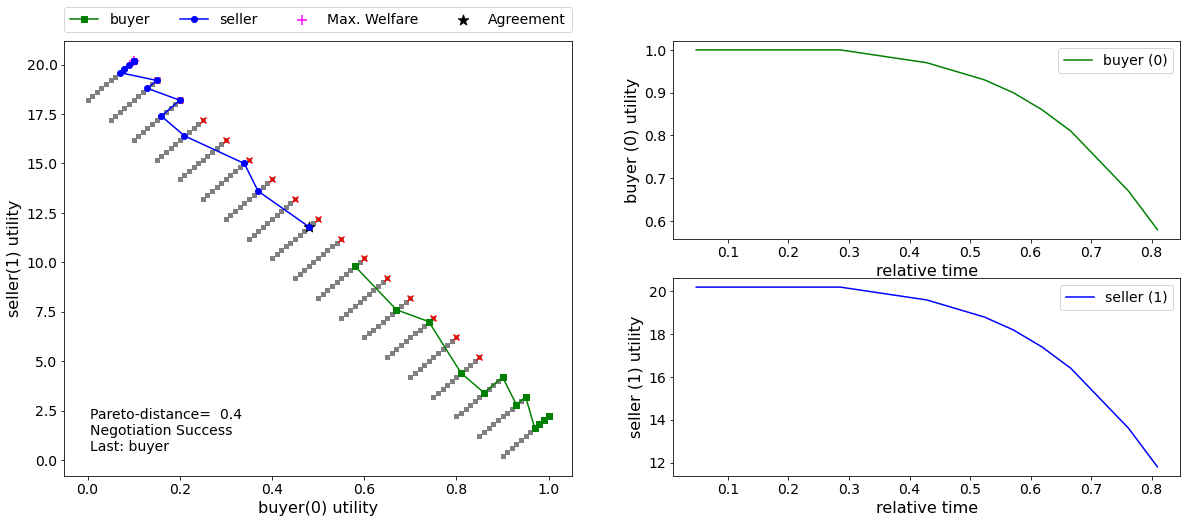

In [5]:
session.plot(plot_outcomes=False)

What happens if the seller was much more interested in delivery time. 

Firstly, what do you expect? 

Given that delivery time becomes a more important issue now, the seller will get more utility points by allowing the price to go down given that the delivery time can be made earlier. This means that we should expect the delivery time and price to go down. Let's see what happens:

In [6]:

seller_utility = normalize(ufun=LUFun(values={'price': lambda x: x
                                       , 'quantity': lambda x: 0.2 * x
                                       , 'delivery_time': lambda x: 9.0 - x}
                                     , weights = {'price': 1.0, 'quantity': 1.0, 'delivery_time': 10.0})
                         , outcomes=session.outcomes)

session = SAOMechanism(issues=issues, n_steps=50)
session.add(AspirationNegotiator(name='buyer'), ufun=buyer_utility)
session.add(AspirationNegotiator(name='seller'), ufun=seller_utility)
pprint(session.run().__dict__)

{'agreement': (5, 2, 5),
 'broken': False,
 'current_offer': (5, 2, 5),
 'current_proposer': 'seller-88b019eb-da2a-4989-8e62-afc9a4bd48c7',
 'current_proposer_agent': None,
 'error_details': '',
 'has_error': False,
 'last_negotiator': <negmas.sao.negotiators.AspirationNegotiator object at 0x127545af0>,
 'n_acceptances': 0,
 'n_negotiators': 2,
 'new_offerer_agents': [],
 'new_offers': [],
 'relative_time': 0.9019607843137255,
 'results': None,
 'running': False,
 'started': True,
 'step': 45,
 'time': 0.01624198899999918,
 'timedout': False,
 'waiting': False}


We can check it visually as well:

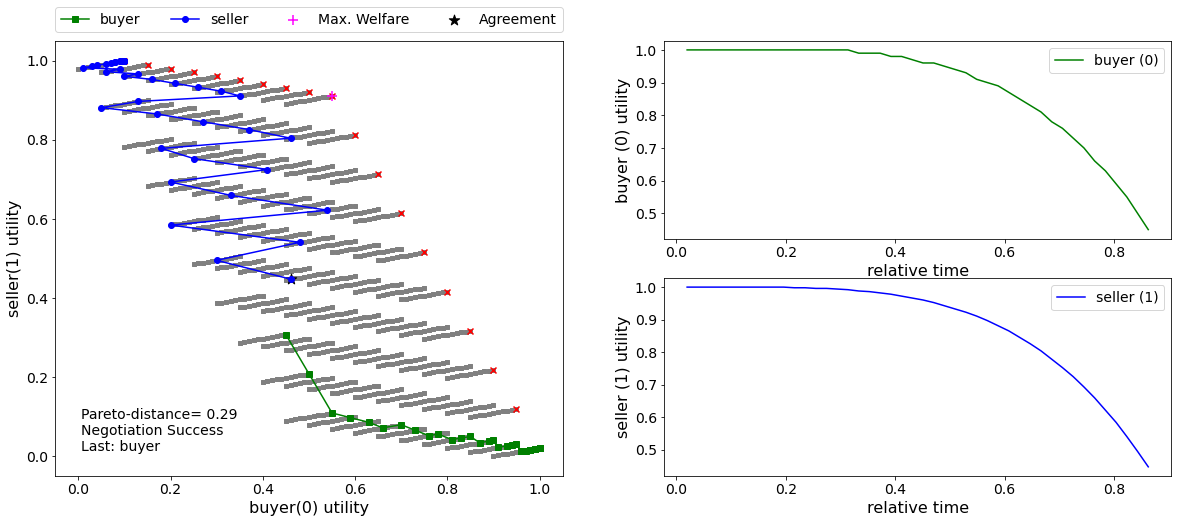

In [7]:
session.plot(plot_outcomes=False)

It is clear that the new ufuns transformed the problem. Now we have a single outcome at the pareto front. Nevertheless, there is money on the table as the negotiators did not agree on an outcome on the pareto front. 

What happens if we give them more time to negotiate:


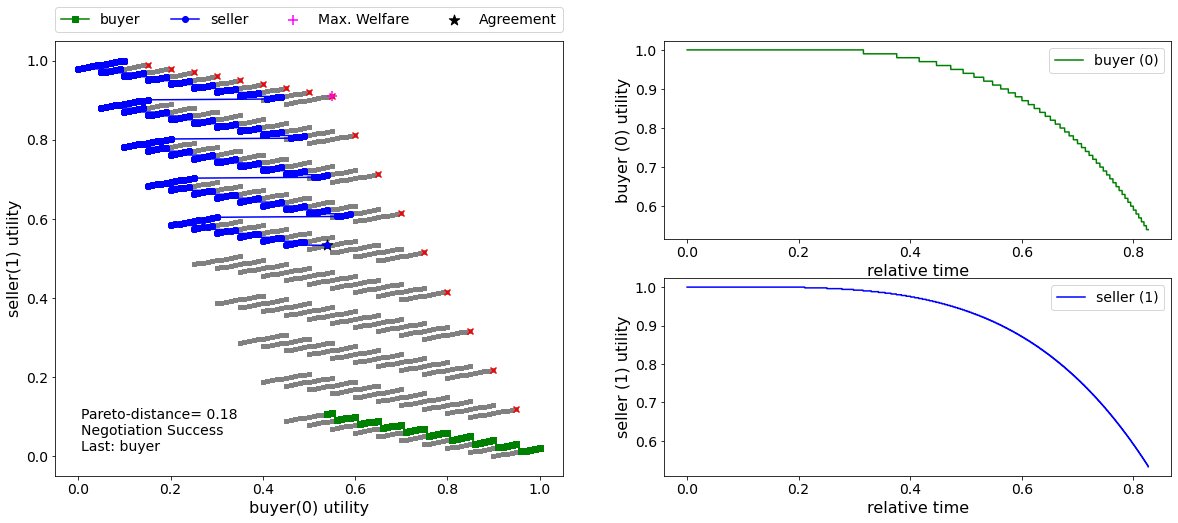

In [8]:
session = SAOMechanism(issues=issues, n_steps=5000)

seller_utility = normalize(ufun=LUFun(values={'price': lambda x: x
                                       , 'quantity': lambda x: 0.2 * x
                                       , 'delivery_time': lambda x: 9.0 - x}
                                     , weights = {'price': 1.0, 'quantity': 1.0, 'delivery_time': 10.0})
                         , outcomes=session.outcomes)

session.add(AspirationNegotiator(name='buyer'), ufun=buyer_utility)
session.add(AspirationNegotiator(name='seller'), ufun=seller_utility)
session.run()
session.plot(plot_outcomes=False)

It did not help much! The two agents adjusted their concession to match the new time and they did not get to the Pareto-front. 

Let's allow them to concede faster by setting their `aspiration_type` to *linear* instead of the default *boulware*:


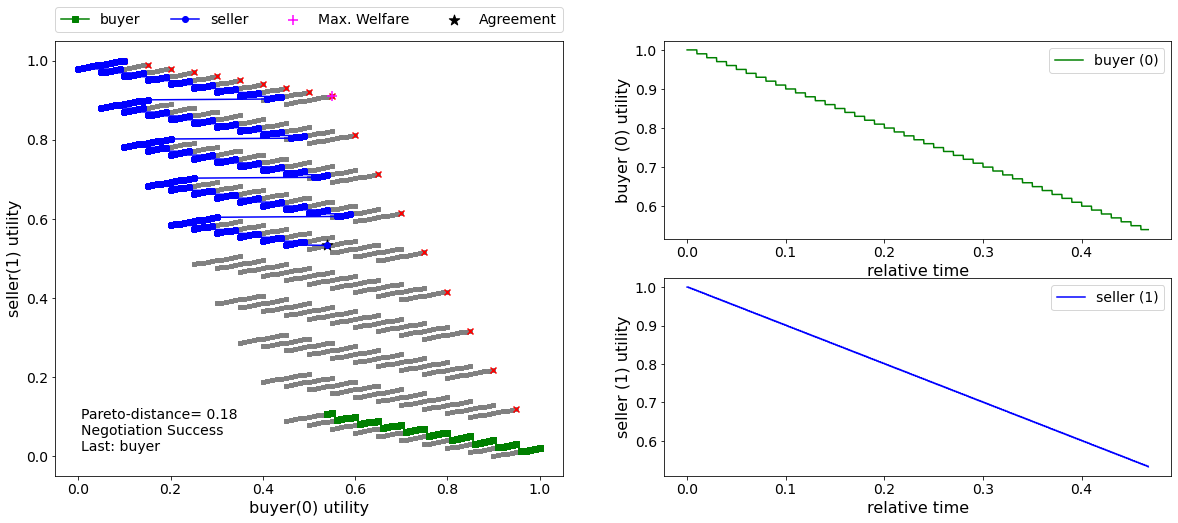

In [9]:
seller_utility = normalize(ufun=LUFun(values={'price': lambda x: x
                                       , 'quantity': lambda x: 0.2 * x
                                       , 'delivery_time': lambda x: 9.0 - x}
                                     , weights = {'price': 1.0, 'quantity': 1.0, 'delivery_time': 10.0})
                         , outcomes=session.outcomes)

session = SAOMechanism(issues=issues, n_steps=5000)
session.add(AspirationNegotiator(name='buyer', aspiration_type="linear"), ufun=buyer_utility)
session.add(AspirationNegotiator(name='seller', aspiration_type="linear"), ufun=seller_utility)
session.run()
session.plot(plot_outcomes=False)

It is clear that longer negotiation time, and faster concession did not help the negotiators get to a point on the pareto-front. 

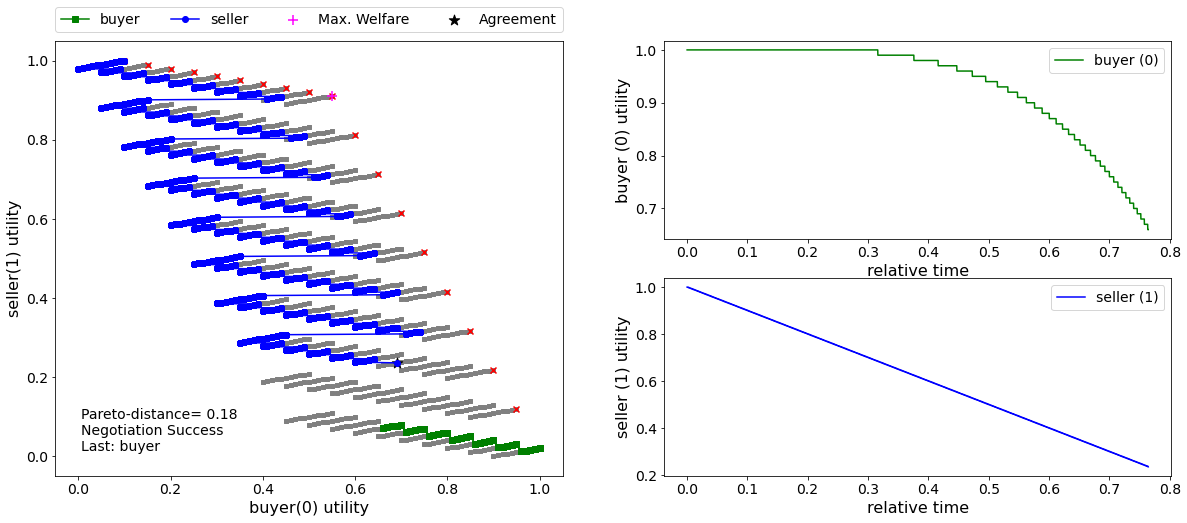

In [10]:
session = SAOMechanism(issues=issues, n_steps=5000)
session.add(AspirationNegotiator(name='buyer', aspiration_type="boulware"), ufun=buyer_utility)
session.add(AspirationNegotiator(name='seller', aspiration_type="linear"), ufun=seller_utility)
session.run()
session.plot(plot_outcomes=False)